<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis/blob/main/BulkAnalyze_powerspectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import Image
import scipy
import time

def get_relative_power_spectrum(signal):
  ps = np.square(np.abs(scipy.fft.rfft(signal)))
  #normalize to sum to 1
  return ps/np.sum(ps)

def get_minfdr(zscores):
  argsort_zscores = np.argsort(-zscores)
  sorted_zscores = zscores[argsort_zscores]
  pvals_zscores = 1 - scipy.stats.norm.cdf(sorted_zscores)
  fdrs_zscores = (pvals_zscores*(len(zscores)))/(np.arange(len(zscores))+1)
  argmin_fdr = np.argmin(fdrs_zscores)
  minfdr = fdrs_zscores[argmin_fdr]
  return fdrs_zscores[argmin_fdr], pvals_zscores[argmin_fdr], ((argmin_fdr+1)/len(zscores))

def get_normalized_power_spectrum_welch(signal, nperseg):
  freqs, ps = scipy.signal.welch(
    signal, nperseg=nperseg, window='boxcar', detrend=False, scaling='spectrum')

  #due to the symmetry property of the fourier transform for real-valued signals,
  # certain frequencies in the power spectrum
  # for real inputs have their power doubled. But we are interested in how the power
  # spectrum differs from a uniform power spectrum, so we need to undo that
  # doubling. Reference: https://github.com/scipy/scipy/blob/686422c4f0a71be1b4258309590fd3e9de102e18/scipy/signal/_spectral_py.py#L1900
  if nperseg%2: #if nperseg is odd
    ps[1:] /= 2
  else:
    ps[1:-1] /= 2

  #If we want to extract autocorrelation, we can do so with this formula:
  #autocorrs = np.real(scipy.fft.irfft(ps*np.square(nperseg))) - ps[0]*nperseg #subtract ps[0]*nperseg to subtract (mean^2)*nperseg

  return freqs, ps/np.sum(ps)

def get_smoothed_arr(arr, windowsize):
  arr_cumsum = np.array([0] + list(np.cumsum(arr)))
  smooth_arr = (arr_cumsum[windowsize:] - arr_cumsum[:-windowsize])/windowsize
  return smooth_arr

def get_smoothed_arrs(arrs, windowsize):
  arr_cumsum = np.pad(np.cumsum(arrs, axis=1), ((0,0),(1,0)))
  smooth_arr = (arr_cumsum[:,windowsize:] - arr_cumsum[:,:-windowsize])/windowsize
  return smooth_arr

def perform_powerspectrum_analysis(values, num_permutations, saveprefix, loadifpresent):

  toreturndict = {}

  start = time.time()
  rng = np.random.RandomState(1234)
  rng_permutations = np.array([rng.permutation(values)
                               for i in range(num_permutations)])

  #print("cp0", time.time()-start)
  for (nperseg, npersegname) in [(len(values), "NA"),
                                 (60*60, "60min"),
                                 (60*30, "30min"),
                                 ]:
    nperseg_saveprefix = saveprefix+"_nperseg-"+npersegname

    freqs, nps = get_normalized_power_spectrum_welch(values, nperseg)

    #load the welch power spectrum run on the permutation controls, as this
    # can take some time
    npspermute2darr_savefilepath = nperseg_saveprefix+"_npspermute2darr.npy"
    if (loadifpresent and os.path.isfile(npspermute2darr_savefilepath)):
      nps_permute_2darr = np.load(npspermute2darr_savefilepath)
    else:
      #permute the test data sequence num_permutations times to get an empirical null
      nps_permute_2darr = np.array([
          get_normalized_power_spectrum_welch(rng_permutation, nperseg)[1]
          for rng_permutation in rng_permutations])
      np.save(npspermute2darr_savefilepath, nps_permute_2darr)
    #print("cp1", time.time()-start)

    uniform_expectation = 1.0/len(nps)

    expected_freq = np.sum(freqs*nps)
    expected_freq_permute_arr = np.sum(freqs[None,:]*nps_permute_2darr, axis=1)
    pval_ef = np.mean(expected_freq_permute_arr >= expected_freq)
    toreturndict['pval_nperseg-'+npersegname+'_ef'] = pval_ef

    maxd = np.max(np.abs(np.cumsum(nps - uniform_expectation)))
    maxd_permute_arr = np.max(np.abs(np.cumsum(nps_permute_2darr - uniform_expectation, axis=1)), axis=1);
    pval_maxd = np.mean(maxd_permute_arr >= maxd)
    toreturndict['pval_nperseg-'+npersegname+'_maxd'] = pval_maxd

    freq_stepsize = freqs[1]
    smoothfreqwindows = [('p0075', 0.0075),
                         ('p01', 0.01),
                         ('p0125', 0.0125),
                         ('p015', 0.0125),
                         ('p02', 0.02),
                         ('p025', 0.025),
                         ('p03', 0.03),
                         ]
    #print("cp2", time.time()-start)
    for (smoothfreqname, smoothfreqwindow) in smoothfreqwindows:
      windowsize = int(smoothfreqwindow/freq_stepsize)
      smooth_nps = get_smoothed_arr(nps, windowsize)
      smooth_xaxis = get_smoothed_arr(freqs, windowsize)
      argmax_smooth_nps = np.argmax(smooth_nps)
      max_smooth_nps = smooth_nps[argmax_smooth_nps]
      toreturndict['peakfreq_nperseg-'+npersegname+'_smooth-'+smoothfreqname] = smooth_xaxis[argmax_smooth_nps]

      #computing max_smooth_nps_permute_2darr can take a while, so save it
      maxsmoothnpspermute2darr_savefilepath = (
          nperseg_saveprefix+'_smooth-'+smoothfreqname+"_maxsmoothnpspermute2darr.npy")
      if (loadifpresent and os.path.isfile(maxsmoothnpspermute2darr_savefilepath)):
        max_smooth_nps_permute_2darr = np.load(maxsmoothnpspermute2darr_savefilepath)
      else:
        max_smooth_nps_permute_2darr = np.max(
          get_smoothed_arrs(nps_permute_2darr, windowsize), axis=1)
        np.save(maxsmoothnpspermute2darr_savefilepath,
                max_smooth_nps_permute_2darr)

      pval_smooth = np.mean(max_smooth_nps_permute_2darr >= max_smooth_nps)
      toreturndict['pval_nperseg-'+npersegname+'_smooth-'+smoothfreqname] = pval_smooth

    #print("cp3", time.time()-start)

  return (toreturndict, (freqs, nps))



In [ ]:
def get_chisquareminus1(egg_values):
  #print("Num nan:", np.sum(np.isnan(egg_values)))
  #Radin 2023 (Anomalous entropic effects in physical systems associated
  # with collective consciousness) said "All individual samples within a matrix
  # less than 55 or greater than 145 were set to nan" so we do that here
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)
  #print("Num nan post mask:", np.sum(np.isnan(egg_values)))

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row
  #If any rows are all-nan, aboort as if we dropped that row it would mess
  # up the temporal spacing
  #assert (np.sum(num_nonnan_eggs==0)==0), np.sum(num_nonnan_eggs==0)

  sum_eggs = np.nansum(egg_values, axis=1) #get the sum across all eggs - NaNs are automatically skipped
  z_sum_eggs = (sum_eggs - num_nonnan_eggs*100)/np.sqrt(num_nonnan_eggs*200*0.25) #get z scores as per a binomial dist

  return np.square(z_sum_eggs)-1, z_sum_eggs


In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
event_metadata_list = json.load(open("/content/drive/MyDrive/GCP_data/event_metadata_list.json"))

In [54]:
%matplotlib inline

import glob
import json
import numpy as np
import scipy
import os
from matplotlib import pyplot as plt

%cd /content/drive/MyDrive/GCP_data/

NUM_PERMUTATIONS = 1000

generalstats = {"test": [], "control1": [], "control2": [], "control3": [], "control4": []}
csm1_psanalysis = {"test": [], "control1": [], "control2": [], "control3": [], "control4": []}
#compositez_psanalysis = {"test": [], "control1": [], "control2": [], "control3": [], "control4": []}

event_count = 0

dont_rerun_if_cache_file_exists = False #For a fresh run, set to False so nothing is loaded, all saved
cachesavefolder = "/content/drive/MyDrive/GCP_data/analysis/cache_v20231022/"
!mkdir $cachesavefolder

for (event, event_name, pval) in event_metadata_list[:]:

  event_count += 1
  print("\n--------------------------------")
  print("Event Count:",event_count,event,event_name,pval)

  for spanname in ['test', 'control1', 'control2', 'control3', 'control4']:
    print("span:", spanname)
    egg_values = np.load("extracted/"+event+"_"+spanname+"_eggvalues.npy")

    csm1, z_sum_eggs = get_chisquareminus1(egg_values)

    csm1_zscore = np.sum(csm1)/np.sqrt(2*len(csm1)) #variance of chi-squared with df=1 is 2

    spangeneralstats = {
      'csm1_zscore': csm1_zscore,
      'length': len(csm1)}
    generalstats[spanname].append(spangeneralstats)

    print(spanname, spangeneralstats)

    for signaltype,signal,signalsavedict in [("csm1", csm1, csm1_psanalysis),
                                             #("compositez", z_sum_eggs, compositez_psanalysis)
                                             ]:
      saveprefix = cachesavefolder+"/"+event+"_"+spanname+"_"+signaltype+"_nperm-"+str(NUM_PERMUTATIONS)
      if (dont_rerun_if_cache_file_exists and os.path.exists(saveprefix+"_psanalysis.json")):
        ps_analysis = json.load(open(saveprefix+"_psanalysis.json"))
      else:
        ps_analysis, _ = perform_powerspectrum_analysis(
            signal, NUM_PERMUTATIONS, saveprefix, dont_rerun_if_cache_file_exists)
        open(saveprefix+"_psanalysis.json",'w').write(json.dumps(ps_analysis))
      print(signaltype, ps_analysis)
      signalsavedict[spanname].append(ps_analysis)


/content/drive/MyDrive/GCP_data
mkdir: cannot create directory ‘/content/drive/MyDrive/GCP_data/analysis/cache_v20231022/’: File exists

--------------------------------
Event Count: 1 Event391 Internat Day Peace 0.0008192443394802185
span: test
test {'csm1_zscore': 3.148966694327055, 'length': 86400}
csm1 {'pval_nperseg-NA_ef': 0.641, 'pval_nperseg-NA_maxd': 0.793, 'peakfreq_nperseg-NA_smooth-p0075': 0.242135416666668, 'pval_nperseg-NA_smooth-p0075': 0.225, 'peakfreq_nperseg-NA_smooth-p01': 0.24120949074073939, 'pval_nperseg-NA_smooth-p01': 0.198, 'peakfreq_nperseg-NA_smooth-p0125': 0.4895659722222212, 'pval_nperseg-NA_smooth-p0125': 0.266, 'peakfreq_nperseg-NA_smooth-p015': 0.4895659722222212, 'pval_nperseg-NA_smooth-p015': 0.266, 'peakfreq_nperseg-NA_smooth-p02': 0.2495659722222222, 'pval_nperseg-NA_smooth-p02': 0.27, 'peakfreq_nperseg-NA_smooth-p025': 0.24876736111111114, 'pval_nperseg-NA_smooth-p025': 0.051, 'peakfreq_nperseg-NA_smooth-p03': 0.25173032407407414, 'pval_nperseg-NA_s

KeyboardInterrupt: ignored

In [35]:
import json

prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_morecontrols"

#save the results
open(prefix+"_csm1_psanalysis.json","w").write(json.dumps(csm1_psanalysis, indent=4))
#open(prefix+"_compositez_psanalysis.json","w").write(json.dumps(pvals_compositez, indent=4))

3923219

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GCP_data

In [103]:
import json
import numpy as np
import scipy

NUM_PERMUTATIONS = 1000

def get_meta_pval(pvals):
  minpval = 1.0/NUM_PERMUTATIONS
  pvals = np.maximum(np.array(pvals), minpval)
  chisquare_stat = -2*np.sum(np.log(pvals))
  deg_freedom = 2*len(pvals)
  return (1 - scipy.stats.chi2.cdf(chisquare_stat, df=deg_freedom))

#load the pvals in case we want to remake the plots without rerunning the prev stuff
prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_morecontrols"

event_metadata_list = json.load(open("/content/drive/MyDrive/GCP_data/event_metadata_list.json"))
generalstats = json.load(open("/content/drive/MyDrive/GCP_data/analysis/generalstats.json"))

csm1_psanalysis = json.load(open(prefix+"_csm1.json"))

#csm1_psanalysis = json.load(open(prefix+"_csm1psanalysis.json"))
#compositez_psanalysis = json.load(open(prefix+"_compositez_psanalysis.json"))

Just dealing with the general stats, I want to understand how the z scores relate to each other

control1 zscores corr: PearsonRResult(statistic=0.055909147229002545, pvalue=0.2676381441336909)


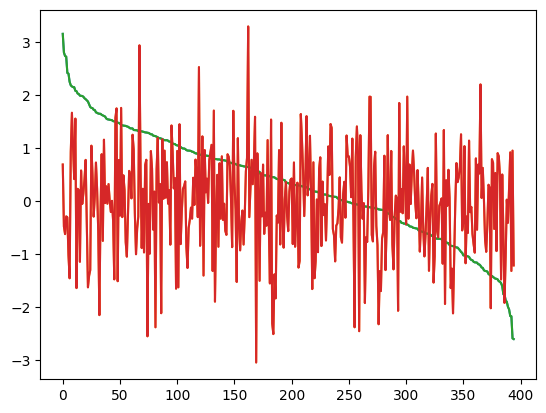

control2 zscores corr: PearsonRResult(statistic=-0.05977734895098678, pvalue=0.2358805112179308)
control3 zscores corr: PearsonRResult(statistic=0.02117973352015264, pvalue=0.674739748321144)
control4 zscores corr: PearsonRResult(statistic=-0.04199331833446998, pvalue=0.40522670627023516)


In [107]:
%matplotlib inline

test_csm1zscores = np.array([x['csm1_zscore'] for x in generalstats['test']])
control1_csm1zscores = np.array([x['csm1_zscore'] for x in generalstats['control1']])
control2_csm1zscores = np.array([x['csm1_zscore'] for x in generalstats['control2']])
control3_csm1zscores = np.array([x['csm1_zscore'] for x in generalstats['control3']])
control4_csm1zscores = np.array([x['csm1_zscore'] for x in generalstats['control4']])

from matplotlib import pyplot as plt

#we are not seeing a correlation in the csm1 zscores...but something is up in the metrics derived from the frequency spectrum...
print("control1 zscores corr:", scipy.stats.pearsonr(test_csm1zscores, control1_csm1zscores))
print("control2 zscores corr:", scipy.stats.pearsonr(test_csm1zscores, control2_csm1zscores))
print("control3 zscores corr:", scipy.stats.pearsonr(test_csm1zscores, control3_csm1zscores))
print("control4 zscores corr:", scipy.stats.pearsonr(test_csm1zscores, control4_csm1zscores))

In [61]:
def get_iterative_metapvals(pvals):
 return np.array([(get_meta_pval(pvals[:i+1])) for i in range(len(pvals))])

metatrends_to_sim = 5000
rng = np.random.RandomState(1234)
savefile = "/content/drive/MyDrive/GCP_data/analysis/simulated_metatrends_nperm"+str(metatrends_to_sim)+".npy"
if (os.path.isfile(savefile)):
  simulated_metapvals_arr = np.load(savefile)
else:
  simulated_metapvals_arr = np.array([-np.log10(
      get_iterative_metapvals(
        np.maximum(rng.uniform(size=len(csm1_psanalysis["test"])),
                  1.0/NUM_PERMUTATIONS)
      ) )
        for i in range(metatrends_to_sim)])
  np.save(savefile, simulated_metapvals_arr)

simulated_metapvals_arr=scipy.stats.norm().ppf(1-np.power(10,-simulated_metapvals_arr))

In [99]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from IPython.core.display import Image, display

#plot how the meta pvalue changes with samples

min_meta = 1 # start the x axis here, min num to include in metaanalysis
max_meta = len(csm1_psanalysis["test"]) #where to stop the plot

def make_meta_trend_plot(title, test_pvals, control1_pvals, control2_pvals, control3_pvals, control4_pvals, savefilename):
  %matplotlib inline

  xaxis_slice = list(range(min_meta,max_meta+1))
  xaxis_full = list(range(1,max_meta+1))

  #floor p values at the lowest detectable
  test_pvals, control1_pvals, control2_pvals, control3_pvals, control4_pvals = [
      np.maximum(arr, 1.0/NUM_PERMUTATIONS) for arr in
       [test_pvals, control1_pvals, control2_pvals, control3_pvals, control4_pvals]]

  test_metapvalzs = scipy.stats.norm().ppf(1-get_iterative_metapvals(test_pvals))
  control1_metapvalzs = scipy.stats.norm().ppf(1-get_iterative_metapvals(control1_pvals))
  control2_metapvalzs = scipy.stats.norm().ppf(1-get_iterative_metapvals(control2_pvals))
  control3_metapvalzs = scipy.stats.norm().ppf(1-get_iterative_metapvals(control3_pvals))
  control4_metapvalzs = scipy.stats.norm().ppf(1-get_iterative_metapvals(control4_pvals))

  theslice = slice(min_meta-1, max_meta)

  handles = []

  rng = np.random.RandomState(1234)

  maxsimmetapvalz_arr = np.max(simulated_metapvals_arr[:,theslice], axis=1)
  maxtestmetapvalz = np.max(test_metapvalzs[theslice])
  maxcontrol1metapvalz = np.max(control1_metapvalzs[theslice])
  maxcontrol2metapvalz = np.max(control2_metapvalzs[theslice])
  maxcontrol3metapvalz = np.max(control3_metapvalzs[theslice])
  maxcontrol4metapvalz = np.max(control4_metapvalzs[theslice])

  minsimmetapvalz_arr = np.min(simulated_metapvals_arr[:,theslice], axis=1)
  mintestmetapval = np.min(test_metapvalzs[theslice])
  mincontrol1metapval = np.min(control1_metapvalzs[theslice])
  mincontrol2metapval = np.min(control2_metapvalzs[theslice])
  mincontrol3metapval = np.min(control3_metapvalzs[theslice])
  mincontrol4metapval = np.min(control4_metapvalzs[theslice])

  print("Testing for positive meta-analysis z-scores:")
  print("test pval:", np.mean(maxtestmetapvalz <= maxsimmetapvalz_arr))
  print("control1 pval:", np.mean(maxcontrol1metapvalz <= maxsimmetapvalz_arr))
  print("control2 pval:", np.mean(maxcontrol2metapvalz <= maxsimmetapvalz_arr))
  print("control3 pval:", np.mean(maxcontrol3metapvalz <= maxsimmetapvalz_arr))
  print("control4 pval:", np.mean(maxcontrol4metapvalz <= maxsimmetapvalz_arr))

  print("Testing for negative meta-analysis z-scores:")
  print("test pval:", np.mean(mintestmetapval >= minsimmetapvalz_arr))
  print("control1 pval:", np.mean(mincontrol1metapval >= minsimmetapvalz_arr))
  print("control2 pval:", np.mean(mincontrol2metapval >= minsimmetapvalz_arr))
  print("control3 pval:", np.mean(mincontrol3metapval >= minsimmetapvalz_arr))
  print("control4 pval:", np.mean(mincontrol4metapval >= minsimmetapvalz_arr))

  print("Looking at correlation of test trendplot with other trendplots")
  print("control1:",scipy.stats.pearsonr(test_metapvalzs[theslice], control1_metapvalzs[theslice]))
  print("control2:",scipy.stats.pearsonr(test_metapvalzs[theslice], control2_metapvalzs[theslice]))
  print("control3:",scipy.stats.pearsonr(test_metapvalzs[theslice], control3_metapvalzs[theslice]))
  print("control4:",scipy.stats.pearsonr(test_metapvalzs[theslice], control4_metapvalzs[theslice]))

  matplotlib.use('agg')
  fig = plt.figure(figsize=(15,4))
  #plot enveloping lines for the 95% and 5% quantiles from the maxsimmetapval_arr
  plt.plot([min_meta,max_meta], [np.percentile(maxsimmetapvalz_arr, 95)]*2, color="orange", linestyle="--")
  plt.plot([min_meta,max_meta], [np.percentile(minsimmetapvalz_arr, 5)]*2, color="orange", linestyle="--")
  #for simulated_metapvals in simulated_metapvals_arr:
  #  plt.plot(xaxis_slice, scipy.stats.norm().ppf(1-np.power(10,-simulated_metapvals[theslice])), color="orange", alpha=0.003)

  plt.scatter(xaxis_full, scipy.stats.norm().ppf(1-test_pvals[:max_meta]), color="blue", s=2)
  plt.scatter(xaxis_full, scipy.stats.norm().ppf(1-control1_pvals[:max_meta]), color="green", s=2)
  plt.scatter(xaxis_full, scipy.stats.norm().ppf(1-control2_pvals[:max_meta]), color="red", s=2)
  plt.scatter(xaxis_full, scipy.stats.norm().ppf(1-control3_pvals[:max_meta]), color="purple", s=2)
  plt.scatter(xaxis_full, scipy.stats.norm().ppf(1-control4_pvals[:max_meta]), color="pink", s=2)

  plt.plot(xaxis_slice, test_metapvalzs[theslice], color="blue")
  plt.plot(xaxis_slice, control1_metapvalzs[theslice], color="green")
  plt.plot(xaxis_slice, control2_metapvalzs[theslice], color="red")
  plt.plot(xaxis_slice, control3_metapvalzs[theslice], color="purple")
  plt.plot(xaxis_slice, control4_metapvalzs[theslice], color="pink")

  plt.plot([min(xaxis_full), max(xaxis_full)],
           [0, 0],
           color="black", linestyle="--")
  plt.plot(xaxis_full, [scipy.stats.norm.ppf(1-x[2]) for x in event_metadata_list[:max_meta]], color="black")
  plt.ylim(-4,5)
  plt.xlabel("Event Number (top ranked first)")
  plt.ylabel("Z-score") #Z-score equivalent derived from inverse-normal-cdf(1-p)
  plt.title(title)
  plt.legend(handles=[mpatches.Patch(color='blue', label='Test signal'),
                      mpatches.Patch(color='green', label='Control 1 signals (before)'),
                      mpatches.Patch(color='red', label='Control 2 signals (after)'),
                      mpatches.Patch(color='purple', label='Control 3 signals (2x before)'),
                      mpatches.Patch(color='pink', label='Control 4 signals (2x after)'),
                      #mpatches.Patch(color='orange', label='Null distribution ('+str(metatrends_to_sim)+' simulated)'),
                      mpatches.Patch(color='black', label='Original event Z-scores')
                    ],
             loc="upper left", ncol=3)
  fig.savefig("analysis/metapval_"+savefilename+'.png')
  plt.close(fig)
  plt.clf()

print("num permutations:",NUM_PERMUTATIONS)

num permutations: 1000


csm1
csm1 nperseg-NA_ef
Testing for positive meta-analysis z-scores:
test pval: 0.0698
control1 pval: 0.6244
control2 pval: 0.1908
control3 pval: 0.6358
control4 pval: 0.4556
Testing for negative meta-analysis z-scores:
test pval: 0.7496
control1 pval: 0.1818
control2 pval: 0.423
control3 pval: 0.1926
control4 pval: 0.1526
Looking at correlation of test trendplot with other trendplots
control1: PearsonRResult(statistic=-0.7292998517260957, pvalue=9.249170690239383e-67)
control2: PearsonRResult(statistic=0.5271333255595487, pvalue=1.2523123518755452e-29)
control3: PearsonRResult(statistic=-0.1633709492277403, pvalue=0.001119782165800236)
control4: PearsonRResult(statistic=0.5440876895276595, pvalue=8.136572325199197e-32)


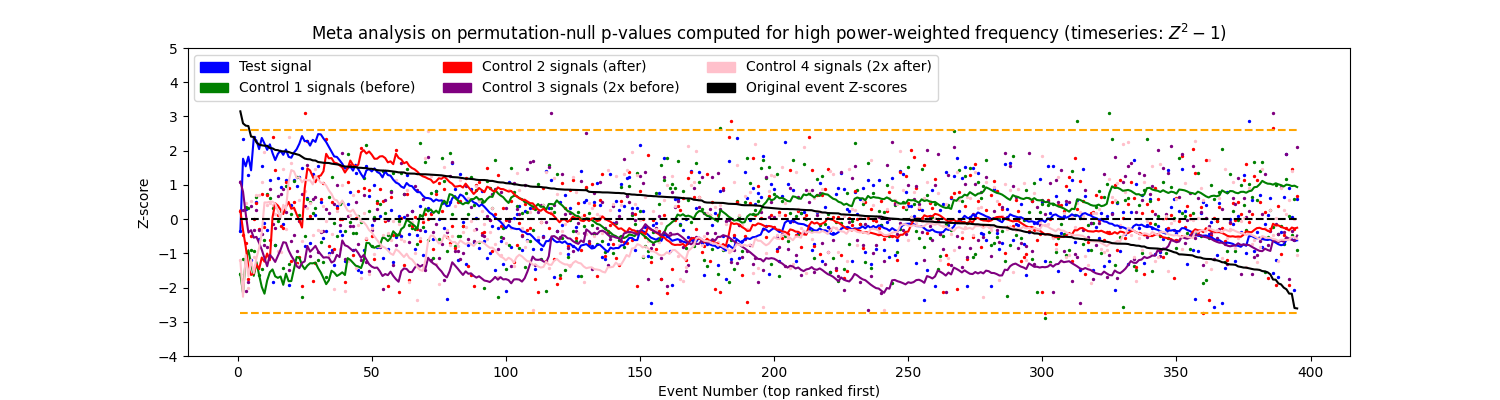

csm1 nperseg-60min_ef
Testing for positive meta-analysis z-scores:
test pval: 0.022
control1 pval: 0.7292
control2 pval: 0.2706
control3 pval: 0.641
control4 pval: 0.5282
Testing for negative meta-analysis z-scores:
test pval: 0.853
control1 pval: 0.1718
control2 pval: 0.364
control3 pval: 0.2174
control4 pval: 0.2096
Looking at correlation of test trendplot with other trendplots
control1: PearsonRResult(statistic=-0.7153743626354193, pvalue=3.6750426866488347e-63)
control2: PearsonRResult(statistic=0.5092007851871092, pvalue=1.9093710088814163e-27)
control3: PearsonRResult(statistic=-0.2789495186029355, pvalue=1.7128239357226113e-08)
control4: PearsonRResult(statistic=0.6722992788405242, pvalue=2.8060269734820466e-53)


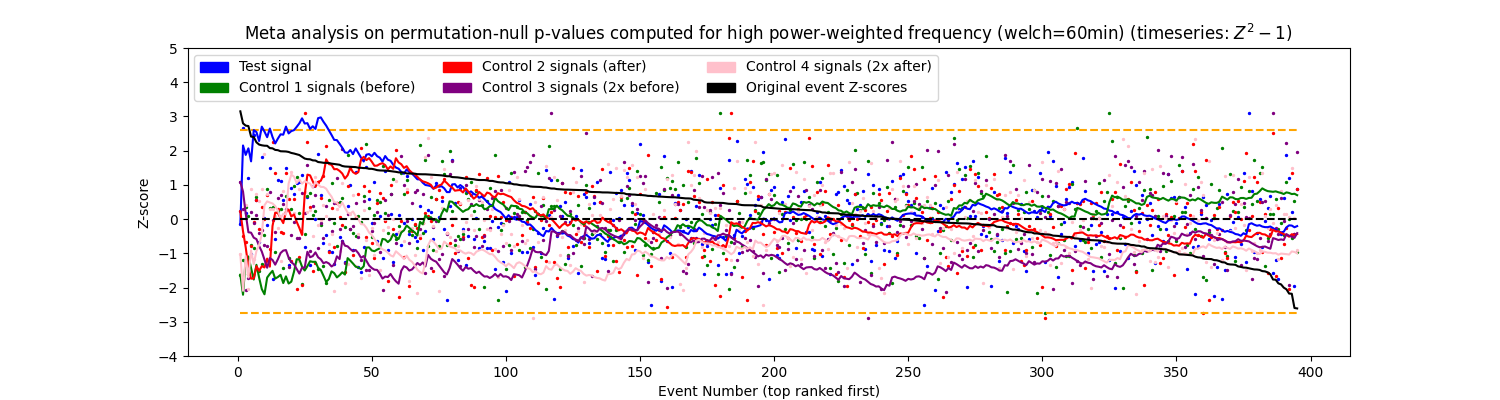

csm1 nperseg-30min_ef
Testing for positive meta-analysis z-scores:
test pval: 0.0538
control1 pval: 0.6764
control2 pval: 0.2494
control3 pval: 0.6288
control4 pval: 0.5758
Testing for negative meta-analysis z-scores:
test pval: 0.8118
control1 pval: 0.1616
control2 pval: 0.3916
control3 pval: 0.2604
control4 pval: 0.1278
Looking at correlation of test trendplot with other trendplots
control1: PearsonRResult(statistic=-0.7104016428352627, pvalue=6.28928235131816e-62)
control2: PearsonRResult(statistic=0.5375436871769517, pvalue=5.880043997563273e-31)
control3: PearsonRResult(statistic=-0.17477329866523184, pvalue=0.00048404057354917574)
control4: PearsonRResult(statistic=0.5365902694133914, pvalue=7.815574059089195e-31)


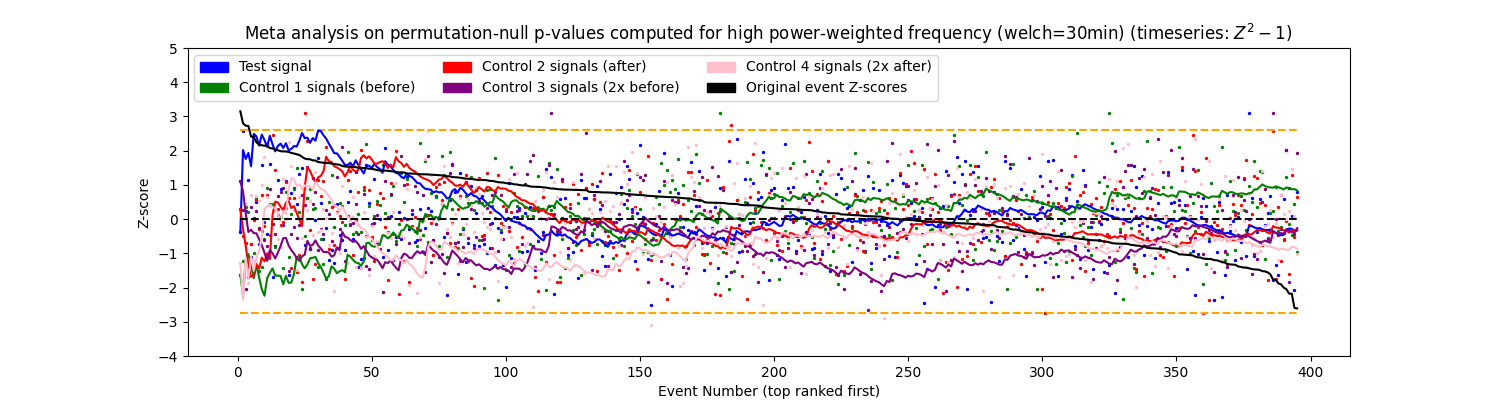

csm1 nperseg-NA_maxd
Testing for positive meta-analysis z-scores:
test pval: 0.216
control1 pval: 0.4164
control2 pval: 0.187
control3 pval: 0.424
control4 pval: 0.4046
Testing for negative meta-analysis z-scores:
test pval: 0.808
control1 pval: 0.8924
control2 pval: 0.5072
control3 pval: 0.284
control4 pval: 0.9706
Looking at correlation of test trendplot with other trendplots
control1: PearsonRResult(statistic=-0.5175757044124023, pvalue=1.8941646626051981e-28)
control2: PearsonRResult(statistic=0.1105660606481279, pvalue=0.02800376616127622)
control3: PearsonRResult(statistic=0.06738786919054994, pvalue=0.1813589071555741)
control4: PearsonRResult(statistic=0.4622761743921633, pvalue=2.6229286303244194e-22)


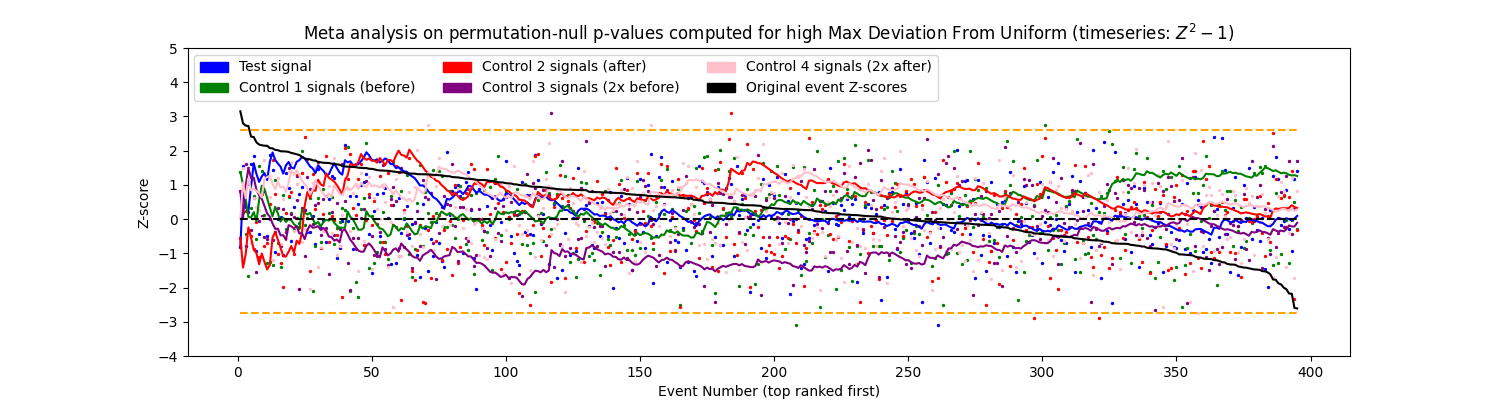

csm1 nperseg-60min_maxd
Testing for positive meta-analysis z-scores:
test pval: 0.1848
control1 pval: 0.364
control2 pval: 0.0998
control3 pval: 0.4028
control4 pval: 0.4956
Testing for negative meta-analysis z-scores:
test pval: 0.7144
control1 pval: 0.9452
control2 pval: 0.4838
control3 pval: 0.1838
control4 pval: 0.9526
Looking at correlation of test trendplot with other trendplots
control1: PearsonRResult(statistic=-0.4656399123040296, pvalue=1.192001850872216e-22)
control2: PearsonRResult(statistic=0.19726381147409544, pvalue=7.914770418722838e-05)
control3: PearsonRResult(statistic=-0.09622344201595451, pvalue=0.05603308518702999)
control4: PearsonRResult(statistic=0.25545388633395383, pvalue=2.6526069314903334e-07)


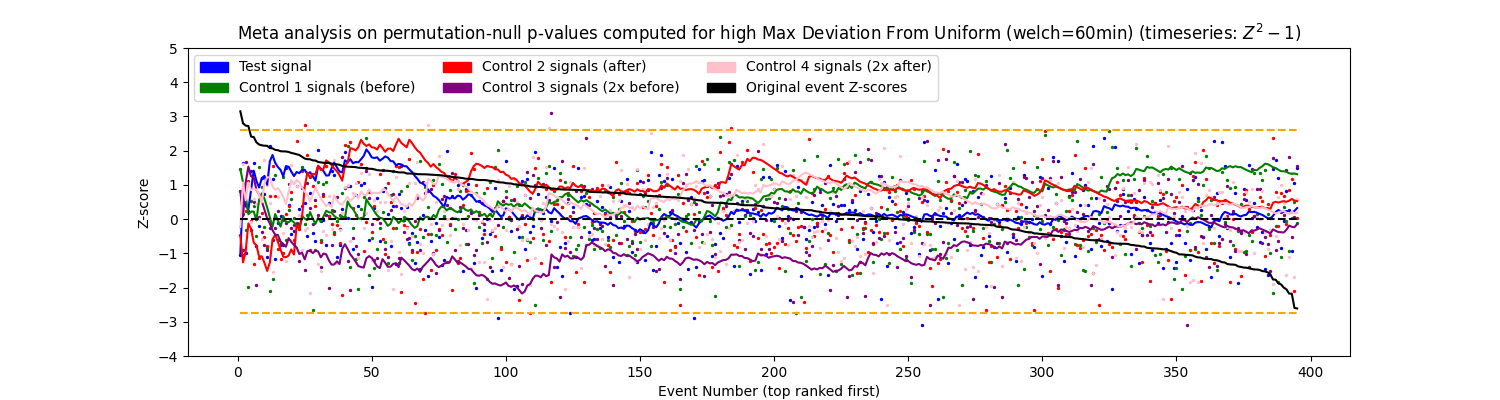

csm1 nperseg-30min_maxd
Testing for positive meta-analysis z-scores:
test pval: 0.1848
control1 pval: 0.3492
control2 pval: 0.1486
control3 pval: 0.4454
control4 pval: 0.4996
Testing for negative meta-analysis z-scores:
test pval: 0.7024
control1 pval: 0.9224
control2 pval: 0.5976
control3 pval: 0.3278
control4 pval: 0.9744
Looking at correlation of test trendplot with other trendplots
control1: PearsonRResult(statistic=-0.38804125902700126, pvalue=1.2093755865357504e-15)
control2: PearsonRResult(statistic=0.1641739397860898, pvalue=0.0010573715483897775)
control3: PearsonRResult(statistic=0.037465152771143935, pvalue=0.45778074873964286)
control4: PearsonRResult(statistic=0.0909659549320083, pvalue=0.07092946447791579)


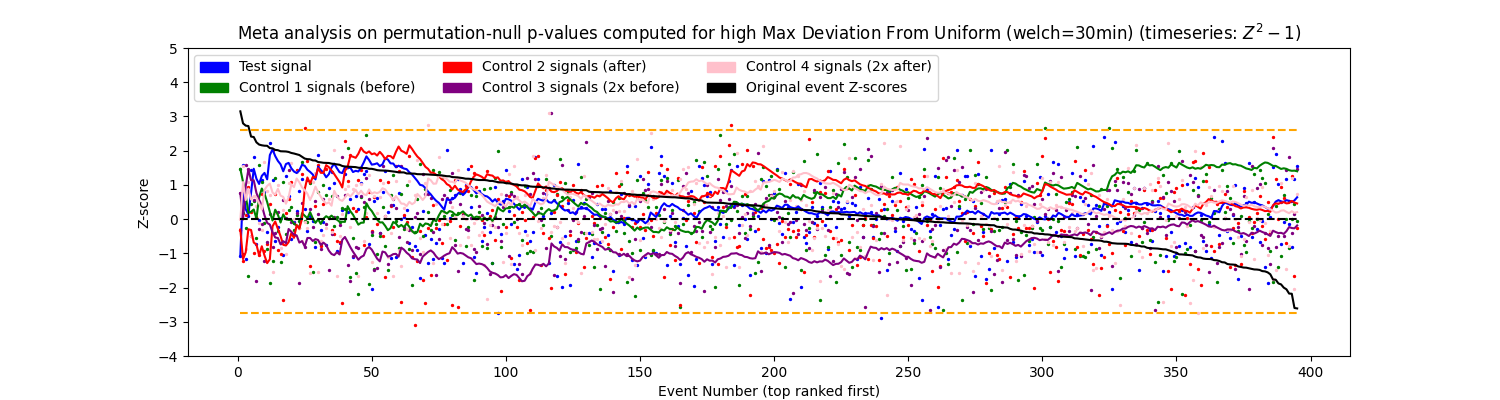

csm1 nperseg-NA_smooth-p0075
Testing for positive meta-analysis z-scores:
test pval: 0.159
control1 pval: 0.9988
control2 pval: 0.5138
control3 pval: 0.4506
control4 pval: 0.8952
Testing for negative meta-analysis z-scores:
test pval: 0.766
control1 pval: 0.0028
control2 pval: 0.682
control3 pval: 0.2026
control4 pval: 0.026
Looking at correlation of test trendplot with other trendplots
control1: PearsonRResult(statistic=-0.6046889902243109, pvalue=9.524687607942366e-41)
control2: PearsonRResult(statistic=0.855977959194932, pvalue=1.1952356454330388e-114)
control3: PearsonRResult(statistic=0.6786118942927288, pvalue=1.2754288655136449e-54)
control4: PearsonRResult(statistic=0.3698903879015757, pvalue=2.976745954055261e-14)


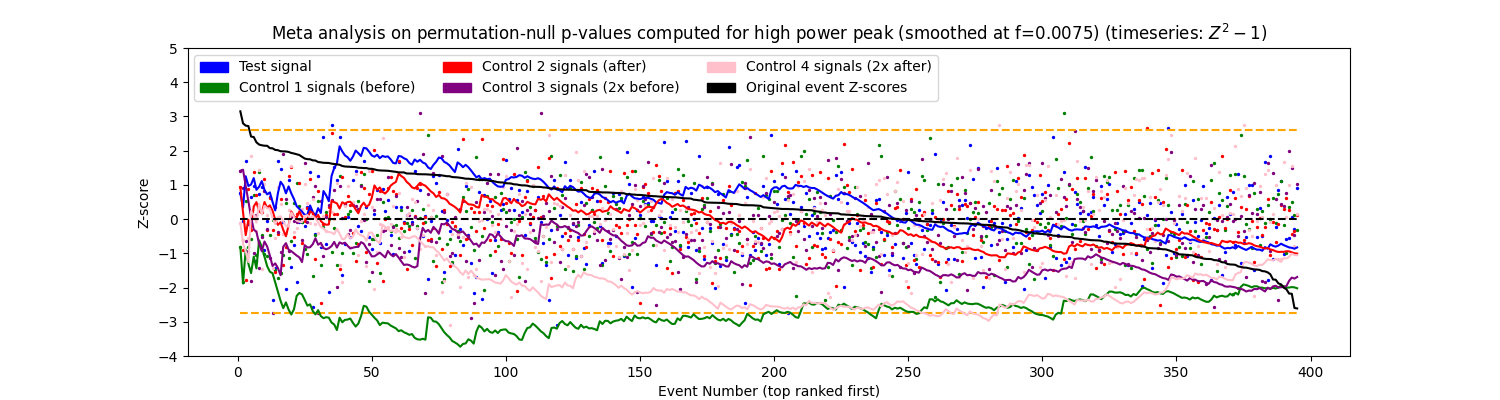

csm1 nperseg-60min_smooth-p0075
Testing for positive meta-analysis z-scores:
test pval: 0.3476
control1 pval: 0.9798
control2 pval: 0.4502
control3 pval: 0.2528
control4 pval: 0.599
Testing for negative meta-analysis z-scores:
test pval: 0.5824
control1 pval: 0.0072
control2 pval: 0.656
control3 pval: 0.1942
control4 pval: 0.0912
Looking at correlation of test trendplot with other trendplots
control1: PearsonRResult(statistic=0.023077610425812196, pvalue=0.6474800291406118)
control2: PearsonRResult(statistic=0.786619251818502, pvalue=2.5782284986449776e-84)
control3: PearsonRResult(statistic=0.6473514382208503, pvalue=2.773589937267707e-48)
control4: PearsonRResult(statistic=0.7724339366929056, pvalue=1.7041401539639685e-79)


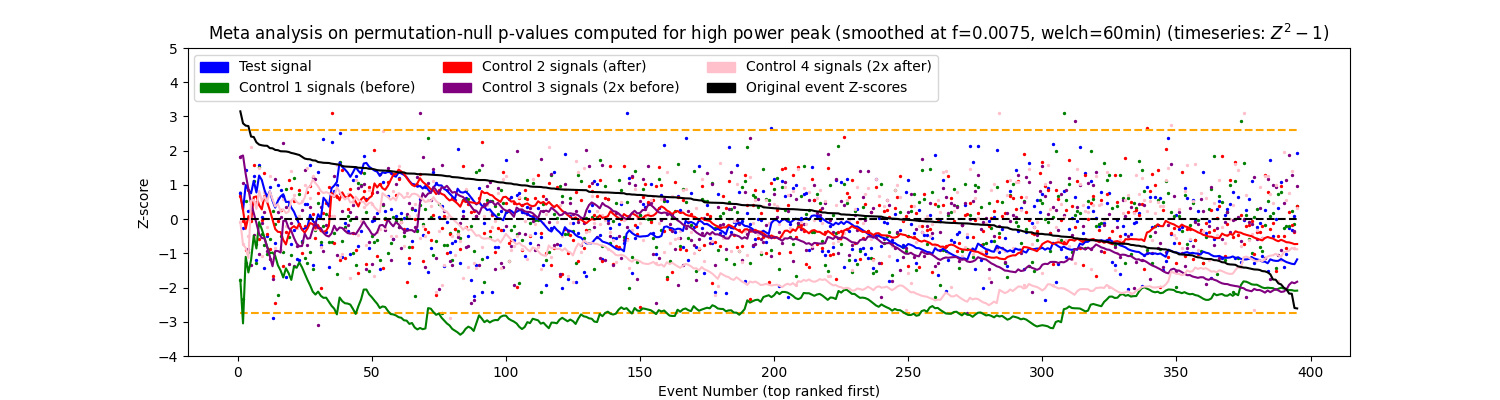

csm1 nperseg-30min_smooth-p0075
Testing for positive meta-analysis z-scores:
test pval: 0.4488
control1 pval: 0.9962
control2 pval: 0.6062
control3 pval: 0.515
control4 pval: 0.6342
Testing for negative meta-analysis z-scores:
test pval: 0.6334
control1 pval: 0.0028
control2 pval: 0.4238
control3 pval: 0.239
control4 pval: 0.0148
Looking at correlation of test trendplot with other trendplots
control1: PearsonRResult(statistic=-0.20873864104947307, pvalue=2.8946058651768762e-05)
control2: PearsonRResult(statistic=0.7829769788806862, pvalue=4.825641189889156e-83)
control3: PearsonRResult(statistic=0.3983785536687082, pvalue=1.781642494776893e-16)
control4: PearsonRResult(statistic=0.7085038976934571, pvalue=1.829851443839748e-61)


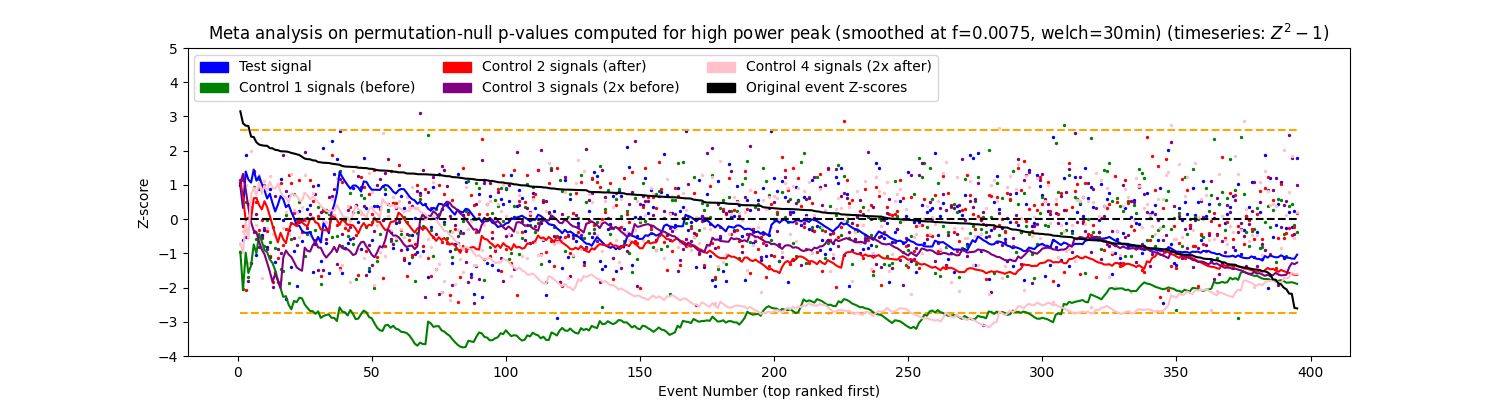

csm1 nperseg-NA_smooth-p01
Testing for positive meta-analysis z-scores:
test pval: 0.0354
control1 pval: 0.9236
control2 pval: 0.701
control3 pval: 0.3694
control4 pval: 0.724
Testing for negative meta-analysis z-scores:
test pval: 0.9568
control1 pval: 0.0496
control2 pval: 0.4478
control3 pval: 0.375
control4 pval: 0.0088
Looking at correlation of test trendplot with other trendplots
control1: PearsonRResult(statistic=-0.7823983280277614, pvalue=7.645573665428528e-83)
control2: PearsonRResult(statistic=0.8007625059370288, pvalue=1.6747751727412946e-89)
control3: PearsonRResult(statistic=0.25032191669098136, pvalue=4.6615929063373703e-07)
control4: PearsonRResult(statistic=0.023390595658623916, pvalue=0.6430282100685943)


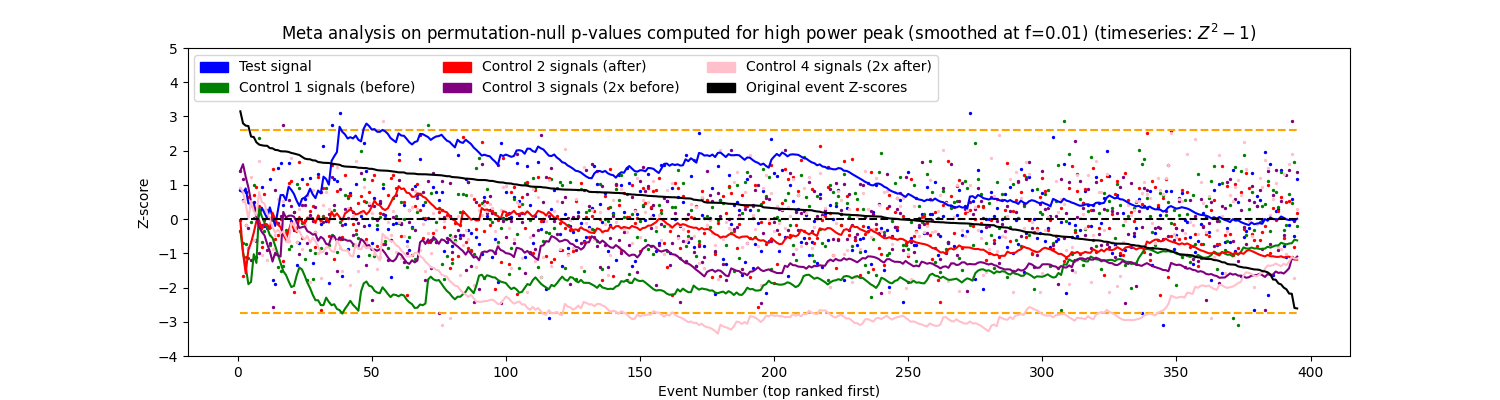

csm1 nperseg-60min_smooth-p01
Testing for positive meta-analysis z-scores:
test pval: 0.0256
control1 pval: 0.7992
control2 pval: 0.5646
control3 pval: 0.2396
control4 pval: 0.6332
Testing for negative meta-analysis z-scores:
test pval: 0.9106
control1 pval: 0.0598
control2 pval: 0.4578
control3 pval: 0.544
control4 pval: 0.026
Looking at correlation of test trendplot with other trendplots
control1: PearsonRResult(statistic=-0.44384459723781927, pvalue=1.6969880799093973e-20)
control2: PearsonRResult(statistic=0.8120894934596892, pvalue=5.727715209659521e-94)
control3: PearsonRResult(statistic=0.4709555540081779, pvalue=3.3669187160238367e-23)
control4: PearsonRResult(statistic=0.6124020123538524, pvalue=5.024520344507017e-42)


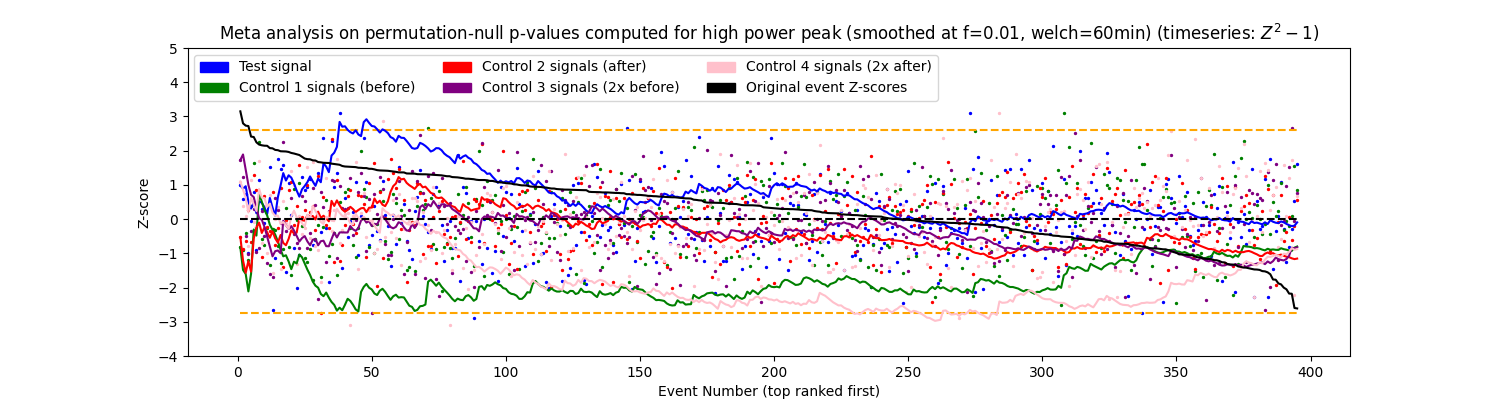

csm1 nperseg-30min_smooth-p01
Testing for positive meta-analysis z-scores:
test pval: 0.0154
control1 pval: 0.8638
control2 pval: 0.934
control3 pval: 0.4498
control4 pval: 0.72
Testing for negative meta-analysis z-scores:
test pval: 0.9852
control1 pval: 0.1998
control2 pval: 0.4692
control3 pval: 0.524
control4 pval: 0.0054
Looking at correlation of test trendplot with other trendplots
control1: PearsonRResult(statistic=-0.741691379961, pvalue=3.7109462528564545e-70)
control2: PearsonRResult(statistic=0.27343373318720826, pvalue=3.337108373714478e-08)
control3: PearsonRResult(statistic=0.5718521473308271, pvalue=1.1169226775591925e-35)
control4: PearsonRResult(statistic=0.24286067677214584, pvalue=1.0354085138669902e-06)


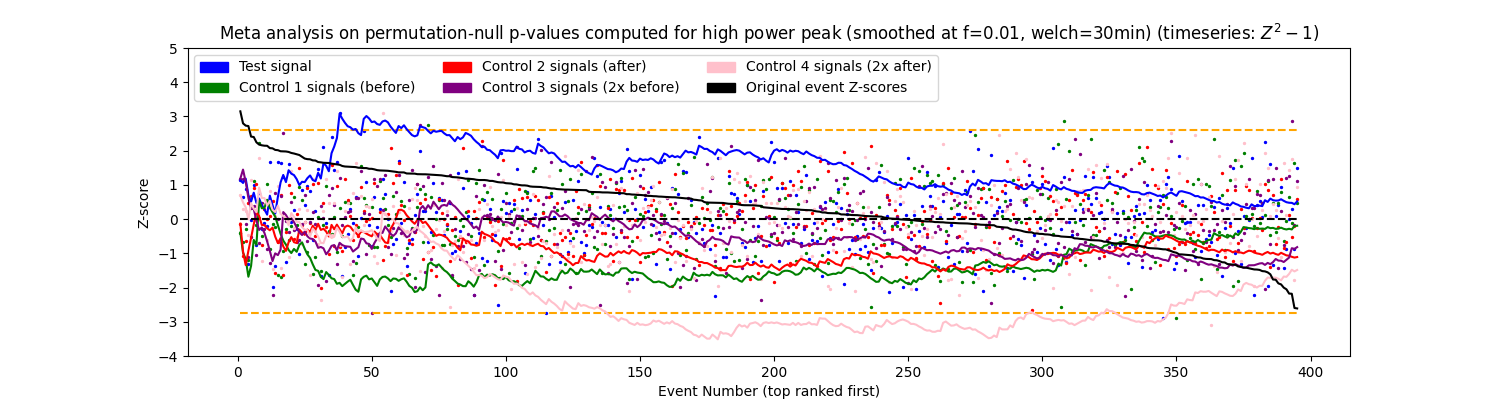

csm1 nperseg-NA_smooth-p0125
Testing for positive meta-analysis z-scores:
test pval: 0.0024
control1 pval: 0.956
control2 pval: 0.5368
control3 pval: 0.4686
control4 pval: 0.652
Testing for negative meta-analysis z-scores:
test pval: 0.9156
control1 pval: 0.0322
control2 pval: 0.678
control3 pval: 0.319
control4 pval: 0.028
Looking at correlation of test trendplot with other trendplots
control1: PearsonRResult(statistic=-0.7171038866015995, pvalue=1.3492143103969164e-63)
control2: PearsonRResult(statistic=0.8182292877950214, pvalue=1.6160657875641091e-96)
control3: PearsonRResult(statistic=0.44597788480655787, pvalue=1.0608952261735033e-20)
control4: PearsonRResult(statistic=-0.3090744458099269, pvalue=3.437854484352257e-10)


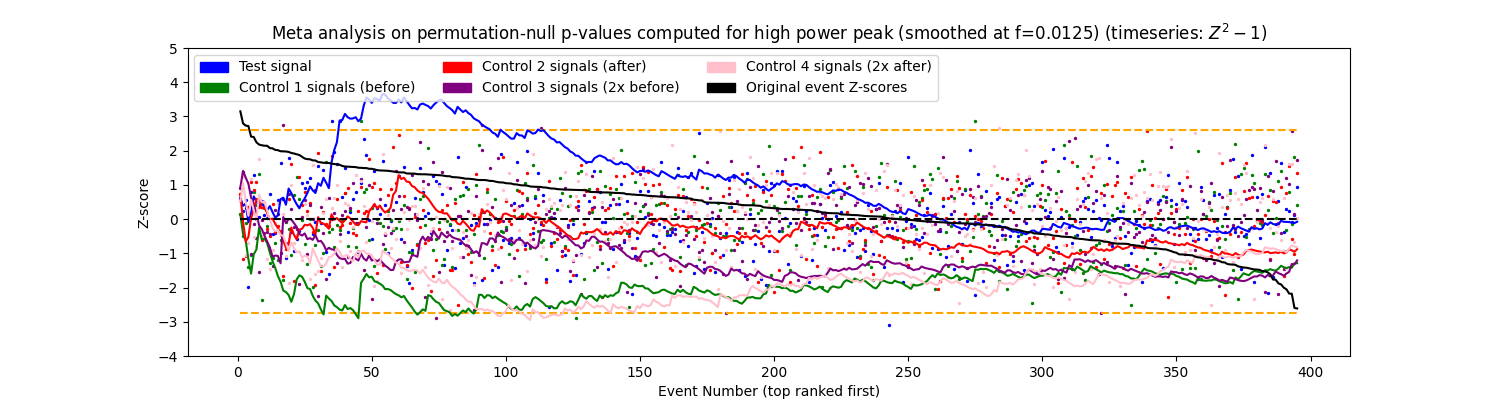

csm1 nperseg-60min_smooth-p0125
Testing for positive meta-analysis z-scores:
test pval: 0.0018
control1 pval: 0.9942
control2 pval: 0.317
control3 pval: 0.503
control4 pval: 0.5988
Testing for negative meta-analysis z-scores:
test pval: 0.9272
control1 pval: 0.024
control2 pval: 0.7154
control3 pval: 0.5888
control4 pval: 0.1578
Looking at correlation of test trendplot with other trendplots
control1: PearsonRResult(statistic=-0.6414485922256201, pvalue=3.6079867408775717e-47)
control2: PearsonRResult(statistic=0.8680710788522098, pvalue=1.3841017321173765e-121)
control3: PearsonRResult(statistic=0.2604850294631829, pvalue=1.508141094972051e-07)
control4: PearsonRResult(statistic=-0.1383404922310534, pvalue=0.00588712124776123)


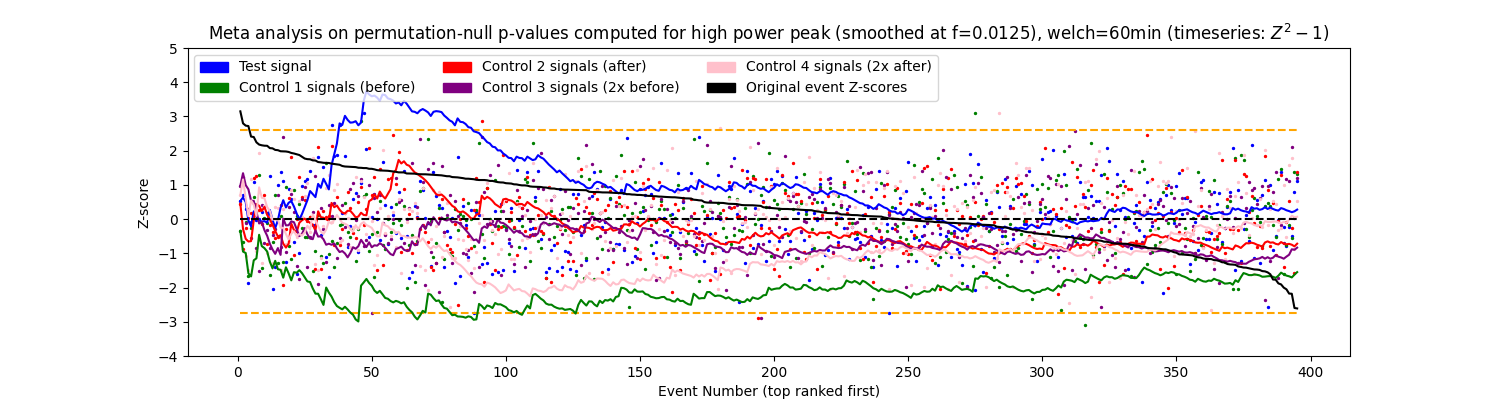

csm1 nperseg-30min_smooth-p0125
Testing for positive meta-analysis z-scores:
test pval: 0.007
control1 pval: 0.9192
control2 pval: 0.7904
control3 pval: 0.6188
control4 pval: 0.6434
Testing for negative meta-analysis z-scores:
test pval: 0.908
control1 pval: 0.1218
control2 pval: 0.4172
control3 pval: 0.6248
control4 pval: 0.1238
Looking at correlation of test trendplot with other trendplots
control1: PearsonRResult(statistic=-0.7663702590885805, pvalue=1.536736471345487e-77)
control2: PearsonRResult(statistic=0.5031460519337198, pvalue=9.755922335338884e-27)
control3: PearsonRResult(statistic=0.26955160773912695, pvalue=5.28948420403599e-08)
control4: PearsonRResult(statistic=-0.10604666477237343, pvalue=0.03512619546021009)


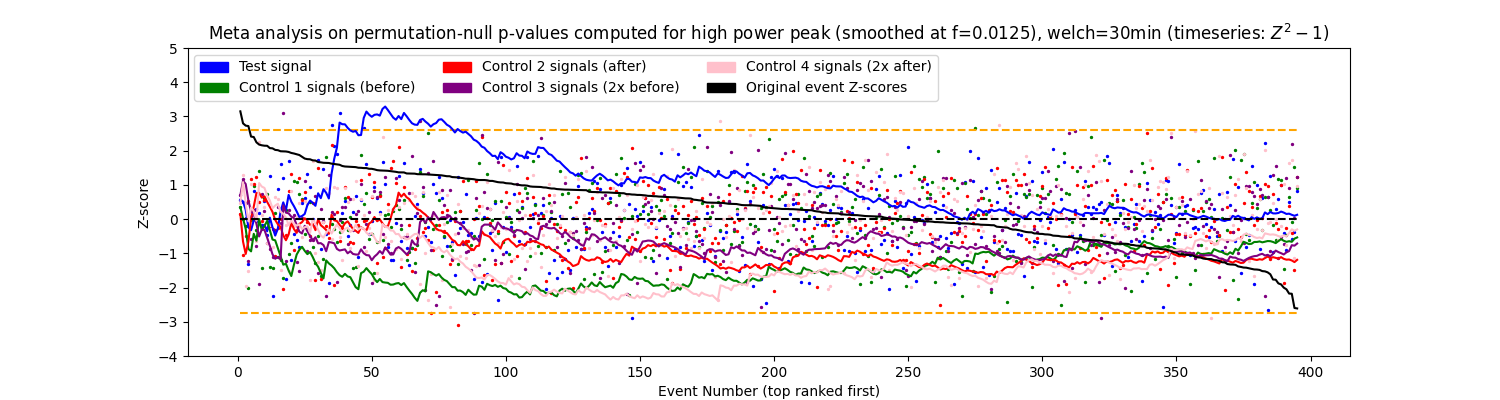

csm1 nperseg-NA_smooth-p025
Testing for positive meta-analysis z-scores:
test pval: 0.0304
control1 pval: 0.824
control2 pval: 0.3528
control3 pval: 0.9092
control4 pval: 0.1262
Testing for negative meta-analysis z-scores:
test pval: 0.7686
control1 pval: 0.2788
control2 pval: 0.7166
control3 pval: 0.0542
control4 pval: 0.5302
Looking at correlation of test trendplot with other trendplots
control1: PearsonRResult(statistic=-0.22606404697232543, pvalue=5.6906328816450236e-06)
control2: PearsonRResult(statistic=0.6970634960215788, pvalue=9.578682273241345e-59)
control3: PearsonRResult(statistic=0.5697161103772039, pvalue=2.2817804473101107e-35)
control4: PearsonRResult(statistic=0.11937566511828206, pvalue=0.01761950490519721)


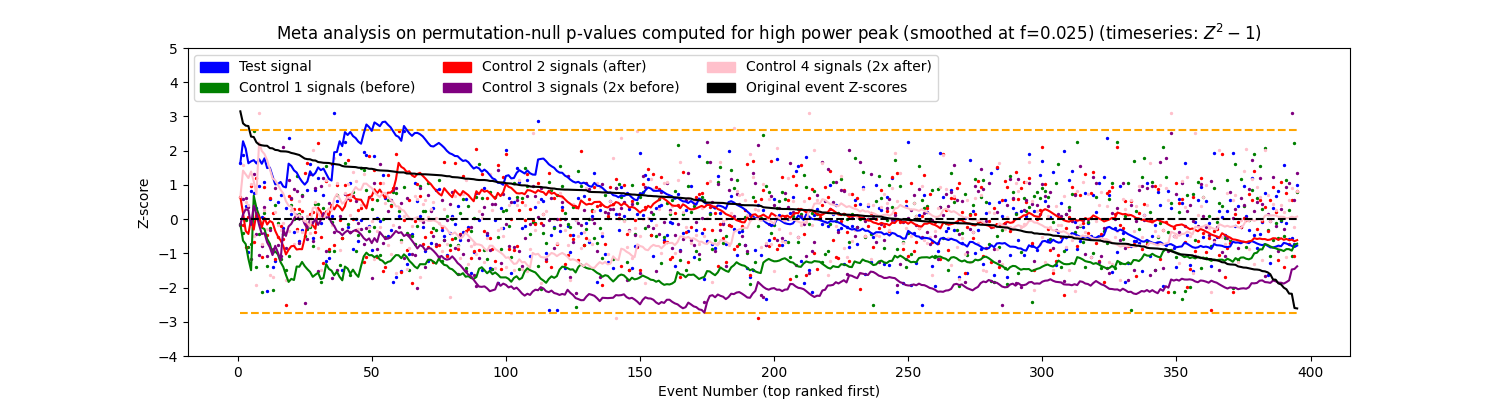

csm1 nperseg-60min_smooth-p025
Testing for positive meta-analysis z-scores:
test pval: 0.0486
control1 pval: 0.7334
control2 pval: 0.157
control3 pval: 0.825
control4 pval: 0.2264
Testing for negative meta-analysis z-scores:
test pval: 0.5564
control1 pval: 0.42
control2 pval: 0.7948
control3 pval: 0.1348
control4 pval: 0.5386
Looking at correlation of test trendplot with other trendplots
control1: PearsonRResult(statistic=-0.3939201665458502, pvalue=4.103227729819748e-16)
control2: PearsonRResult(statistic=0.6953983640340957, pvalue=2.3246189585232626e-58)
control3: PearsonRResult(statistic=0.659064451599056, pvalue=1.4366595132240707e-50)
control4: PearsonRResult(statistic=-0.001223086770760366, pvalue=0.98066807946928)


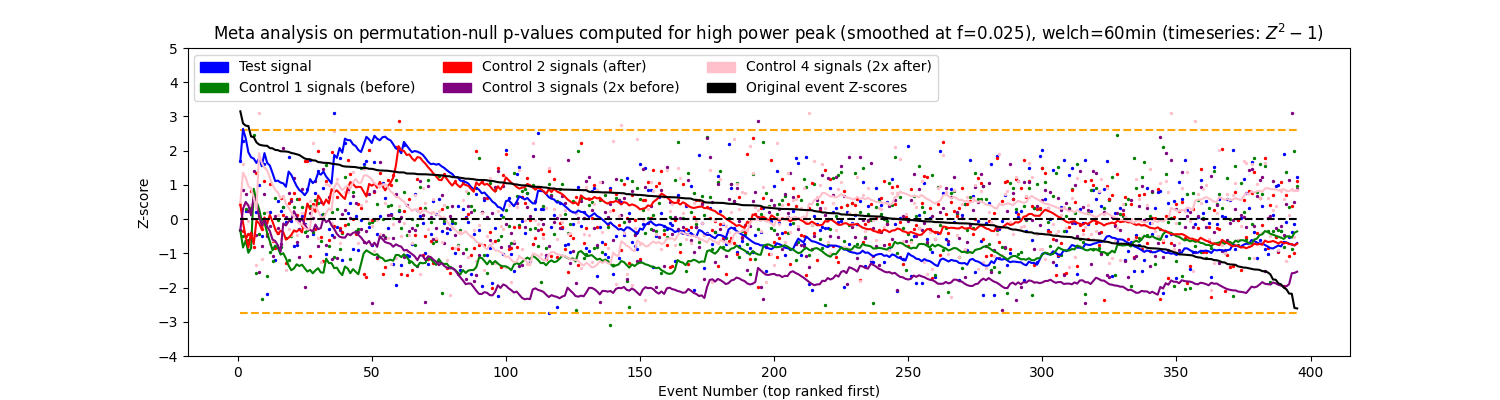

csm1 nperseg-30min_smooth-p025
Testing for positive meta-analysis z-scores:
test pval: 0.0422
control1 pval: 0.7972
control2 pval: 0.2706
control3 pval: 0.7912
control4 pval: 0.1928
Testing for negative meta-analysis z-scores:
test pval: 0.8098
control1 pval: 0.35
control2 pval: 0.7444
control3 pval: 0.0286
control4 pval: 0.6896
Looking at correlation of test trendplot with other trendplots
control1: PearsonRResult(statistic=-0.5728195222761081, pvalue=8.068044507662544e-36)
control2: PearsonRResult(statistic=0.8576878926346054, pvalue=1.3674547641010928e-115)
control3: PearsonRResult(statistic=0.42570637638054853, pvalue=8.0773105452230985e-19)
control4: PearsonRResult(statistic=-0.046430548628102586, pvalue=0.3573842109009949)


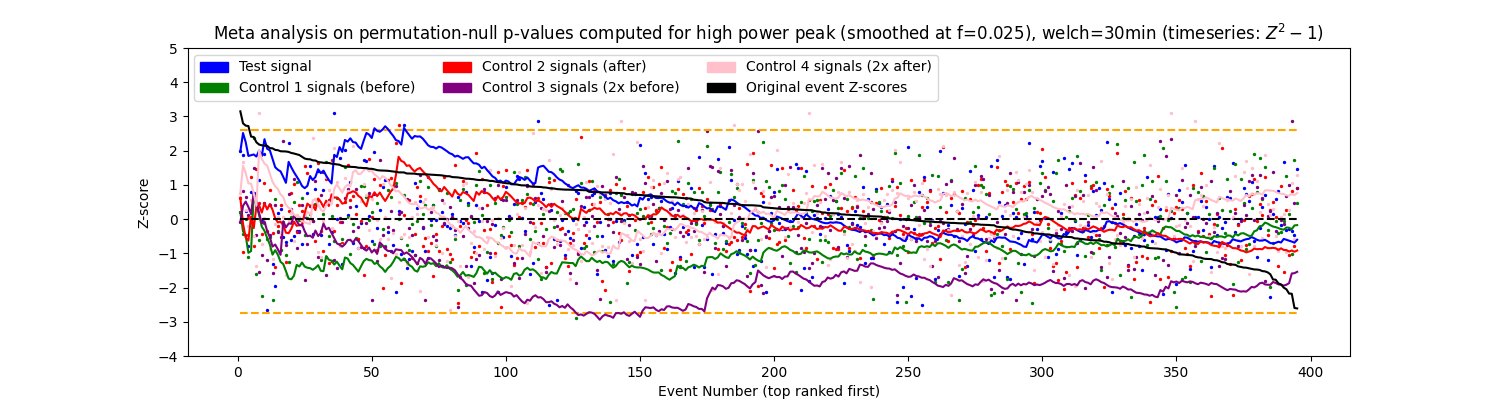

In [100]:
for signalname, signaldisplayname, pvals in [('csm1', '$Z^2 - 1$', csm1_psanalysis),
                                             #('compositez', 'Composite Z', compositez_psanalysis)
                                             ]:
  print(signalname)
  for metricname, metricdisplayname in [
                                        ('nperseg-NA_ef', 'power-weighted frequency'),
                                        ('nperseg-60min_ef', 'power-weighted frequency (welch=60min)'),
                                        ('nperseg-30min_ef', 'power-weighted frequency (welch=30min)'),

                                        ('nperseg-NA_maxd', 'Max Deviation From Uniform'),
                                        ('nperseg-60min_maxd', 'Max Deviation From Uniform (welch=60min)'),
                                        ('nperseg-30min_maxd', 'Max Deviation From Uniform (welch=30min)'),

                                        ('nperseg-NA_smooth-p0075', 'power peak (smoothed at f=0.0075)'),
                                        ('nperseg-60min_smooth-p0075', 'power peak (smoothed at f=0.0075, welch=60min)'),
                                        ('nperseg-30min_smooth-p0075', 'power peak (smoothed at f=0.0075, welch=30min)'),

                                        ('nperseg-NA_smooth-p01', 'power peak (smoothed at f=0.01)'),
                                        ('nperseg-60min_smooth-p01', 'power peak (smoothed at f=0.01, welch=60min)'),
                                        ('nperseg-30min_smooth-p01', 'power peak (smoothed at f=0.01, welch=30min)'),

                                        ('nperseg-NA_smooth-p0125', 'power peak (smoothed at f=0.0125)'),
                                        ('nperseg-60min_smooth-p0125', 'power peak (smoothed at f=0.0125), welch=60min'),
                                        ('nperseg-30min_smooth-p0125', 'power peak (smoothed at f=0.0125), welch=30min'),

                                        ('nperseg-NA_smooth-p025', 'power peak (smoothed at f=0.025)'),
                                        ('nperseg-60min_smooth-p025', 'power peak (smoothed at f=0.025), welch=60min'),
                                        ('nperseg-30min_smooth-p025', 'power peak (smoothed at f=0.025), welch=30min'),

                                        #('nperseg-NA_smooth-p03', 'power peak (smoothed at f=0.03)'),
                                        #('nperseg-60min_smooth-p03', 'power peak (smoothed at f=0.03), welch=60min'),
                                        #('nperseg-30min_smooth-p03', 'power peak (smoothed at f=0.03), welch=30min'),

                                        ]:
    print(signalname,metricname)
    make_meta_trend_plot(
      "Meta analysis on permutation-null p-values computed for high "
        +metricdisplayname+" (timeseries: "+signaldisplayname+")",
      test_pvals=np.array([x["pval_"+metricname] for x in pvals["test"]]),
      control1_pvals=np.array([x["pval_"+metricname] for x in pvals["control1"]]),
      control2_pvals=np.array([x["pval_"+metricname] for x in pvals["control2"]]),
      control3_pvals=np.array([x["pval_"+metricname] for x in pvals["control3"]]),
      control4_pvals=np.array([x["pval_"+metricname] for x in pvals["control4"]]),
      savefilename=signalname+"_"+metricname)
    display(Image("analysis/metapval_"+signalname+"_"+metricname+".png"))

In [ ]:
%matplotlib inline
plt.figure(figsize=(10,4))
_, bins, _ = plt.hist([x["peak_freqs"]['0.0125'] for x in pvals_csm1["test"]],
                      bins=np.linspace(0,0.5,50), color="blue", alpha=0.33)
plt.hist([x["peak_freqs"]['0.0125'] for x in pvals_csm1["control1"]],
         bins=np.linspace(0,0.5,50), color="green", alpha=0.33)
plt.hist([x["peak_freqs"]['0.0125'] for x in pvals_csm1["control2"]],
         bins=np.linspace(0,0.5,50), color="red", alpha=0.33)
plt.legend(handles=[mpatches.Patch(color='blue', label='Test signal', alpha=0.33),
                    mpatches.Patch(color='green', label='Control 1 signals (before)', alpha=0.33),
                    mpatches.Patch(color='red', label='Control 2 signals (after)', alpha=0.33)],
             loc="upper left")
plt.title("Distribution of Frequency Peak in Power Spectrum of $Z^2 - 1$ signal (smoothing=0.0125)")
plt.xlabel("Frequency at Peak Value (50 bins)")
plt.ylabel("Number (out of "+str(len(pvals_csm1["test"]))+")")
plt.show()